# Bayesian Neural Nets for airfoil flows

## Overview

We are looking at the same setup as in the notebook $\textit{Supervised training for RANS flows around airfoils}$: A turbulent airflow around wing profiles, for which we'd like to know the average motion
and pressure distribution around this airfoil for different Reynolds numbers and angles of attack. In the other notebook, we tackled this by completely bypassing any physical solver and instead training a neural network that learns the quantities of interest. Now, we want to extend this approach to so-called Bayesian Neural Networks (short: BNNs). In contrast to traditional networks, that learn a single point estimate for each weight value, BNNs aim at learning a $\textit{distribution}$ over each weight parameter (e.g. a Gaussian with mean $\mu$ and variance $\sigma^{2}$). During a forward-pass, each parameter in the network is then sampled from its corresponding distribution. In that sense, the network parameters themselves are $\textit{random variables}$ and each forward pass becomes $\textit{stochastic}$, because for a given input the predictions will vary with every forward-pass. This allows to assess how $\textit{uncertain}$ the network is: If the predictions vary a lot, we think that the network is uncertain about its output. 


## A quick ride through the theory behind BNNs
Instead of fixed point estimates of the parameters, we aim at learning distributions now. When dealing with BNNs, one therefore assumes a prior distribution $p({w})$ over the network weights ${w}$. Typically, independent Gaussians are used, but other distributions are possible, too. When observing data ${D}$, the prior distribution over the weights is updated to the so-called posterior according to Bayes rule:

$\begin{equation}
p({w}|{D})=\frac{p({D}|{w})p({w})}{p({D})}
\end{equation}
$.

This computation is usually intractable, especially when dealing with non-trivial network architectures. Therefore, the posterior $p({w}|{D})$ is approximated with an easy-to-evaluate variational distribution $q_{\theta}(w)$, parametrized by $\theta$. Again, independent Normal distributions are typically used for each weight. The optimization goal is then to find a distribution $q_{\theta}(w)$ that is close to the true posterior. This can be achieved by minimizing the so-called evidence lower bound (ELBO): 

$\begin{equation}
\mathcal{L}(\theta)=  -E_{q_{\theta}}[\log(p(D|{w}))] +KL(q_{\theta}({w})||p({w}))
\end{equation}
$, 

which is the loss function for BNNs. The first term is an expected negative log-likelhood of the data. Minimizing it means explaining the data as well as possible. In practice, this first term is often an conventional loss functions like mean squared error (note that MSE can be seen as negative log-likelihood for normal noise with unit variance). The second term is the KL-divergence between the approximate posterior and the prior. Minimizing it means encouraging the network weight distributions to stay close to the prior distribution. In that sense, the terms have opposite goals: The first time encourages the model to explain the data as well as possible, whereas the second term encourages the model to stay close to the (random) prior distributions, which implies randomness and regularization.

 In practice, the expectation of the log-likelihood is approximated by a single sample during a forward pass. This is, in every forward pass the network weights are sampled from the current posterior distribution, the loss is computed, and the error is backpropagated in order to update the posterior distribution parameters. If you are curious on how one can backpropagate through distributions, you can read about it [here](https://arxiv.org/abs/1505.05424). An excellent, thorough introduction to Bayesian Neural Networks is available in Yarin Gals [thesis](https://mlg.eng.cam.ac.uk/yarin/thesis/thesis.pdf) in chapters 2 & 3.


But now let's jump right in and discover the BNN features along the way!


### Read in Data
Like in the previous notebook we'll skip the data generation process. This example is adapted from [this codebase](https://github.com/thunil/Deep-Flow-Prediction), which you can check out for details. Here, we'll simply download a small set of training data generated with a Spalart-Almaras RANS simulation in [OpenFOAM](https://openfoam.org/).

In [ ]:
# uncomment for final notebook version
# import numpy as np
# import os.path, random

# if not os.path.isfile('data-airfoils.npz'):
#     import urllib.request
#     url="https://ge.in.tum.de/download/2019-deepFlowPred/data.npz"
#     print("Downloading training data (300MB), this can take a few minutes the first time...")
#     urllib.request.urlretrieve(url, 'data-airfoils.npz')

# npfile=np.load('data-airfoils.npz')
# print("Loaded data, {} training, {} validation samples".format(len(npfile["inputs"]),len(npfile["vinputs"])))

# print("Size of the inputs array: "+format(npfile["inputs"].shape))

# # reshape to channels_last for convencience
# X_train = np.moveaxis(npfile["inputs"],1,-1)
# y_train = np.moveaxis(npfile["targets"],1,-1)

# X_val = np.moveaxis(npfile["vinputs"],1,-1)
# y_val = np.moveaxis(npfile["vtargets"],1,-1)


In [ ]:
# Use mount for convenience - will disappear in final notebook
import numpy as np
import os.path, random
from google.colab import drive
drive.mount('/content/gdrive')

npfile=np.load('gdrive/My Drive/data.npz')


print("Loaded data, {} training, {} validation samples".format(len(npfile["inputs"]),len(npfile["vinputs"])))

print("Size of the inputs array: "+format(npfile["inputs"].shape))

# reshape to channels_last for convencience
X_train = np.moveaxis(npfile["inputs"],1,-1)
y_train = np.moveaxis(npfile["targets"],1,-1)

X_val = np.moveaxis(npfile["vinputs"],1,-1)
y_val = np.moveaxis(npfile["vtargets"],1,-1)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Loaded data, 320 training, 80 validation samples
Size of the inputs array: (320, 3, 128, 128)


### Look at Data
Now we have some training data. We can look at it using the code we also used in the original notebook:


Here are all 3 inputs are shown at the top (mask,in x, in y) 
Side by side with the 3 output channels (p,vx,vy) at the bottom:


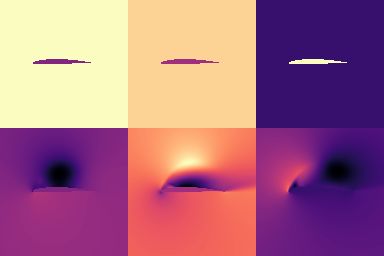

In [ ]:
from PIL import Image
from matplotlib import cm

def show(a, stats=False): # helper to show three target channels, normalized with colormap
    for i in range(3):
        b = np.flipud(a[i].transpose())
        min,mean,max = np.min(b),np.mean(b),np.max(b); 
        if stats: print([b[0,0],min,mean,max])
        b -= min; b /= (max-min)
        if stats: print("{}".format(["p:","ux:","uy:"][i])) # note, for inputs the first channel is the mask...
        display(Image.fromarray( cm.magma(b, bytes=True) ))

def showSbs(a1,a2, stats=False): # helper to show three target channels, normalized with colormap side by side
    c=[]
    for i in range(3):
        b = np.flipud( np.concatenate((a2[:,:,i],a1[:,:,i]),axis=1).transpose())
        min, mean, max = np.min(b), np.mean(b), np.max(b); 
        if stats: print([b[0,0],min,mean,max])
        b -= min; b /= (max-min)
        c.append(b)
    c = np.concatenate(c,axis=1)
    display(Image.fromarray( cm.magma(c, bytes=True) ))

num=40
print("\nHere are all 3 inputs are shown at the top (mask,in x, in y) \nSide by side with the 3 output channels (p,vx,vy) at the bottom:")
showSbs(X_train[num],y_train[num])



### Model Definition
Now let's look at how we can implement BNNs. Instead of PyTorch, we will use TensorFlow, in particular the extension TensorFlow Probability, which has easy-to-implement probabilistic layers. Like in the other notebook, we want to implement a U-Net, consisting of Convolutional blocks with skip-layer connections. For now, we only want to make the decoder, i.e. second part of the U-Net bayesian. For this, we will take advantage of TensorFlows flipout layers (in particular, the convolutional implementation). In a forward pass, those layers automatically sample from the current posterior distribution and store the KL-divergence between prior and posterior in _model.losses_. One can specify the desired divergence measure (typically KL-divergence) and modify the prior and approximate posterior distributions, if other than normal distributions are desired. Other than that, the flipout layers can be used just like regular layers in sequential models. The code below implements a single convolutional block of the U-Net:

In [ ]:
import tensorflow as tf
import tensorflow_probability.python.distributions as tfd
from tensorflow.keras import Sequential
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose,UpSampling2D, BatchNormalization, ReLU, LeakyReLU, SpatialDropout2D, MaxPooling2D
from tensorflow_probability.python.layers import Convolution2DFlipout
from tensorflow.keras.models import Model

def tfBlockUnet(filters=3,transposed=False, kernel_size=3,bn=True,relu=True, pad="same", dropout=0., flipout=False,
              kdf=None,name=''):
    block = Sequential(name=name)
    if relu:
        block.add(ReLU())
    else:
        block.add(LeakyReLU(0.2))
    if not transposed:
        block.add(Conv2D(filters=filters, kernel_size=kernel_size, padding=pad,
                         kernel_initializer=RandomNormal(0.0, 0.02), activation=None,strides=(2,2)))
    else:
        block.add(UpSampling2D(interpolation = 'bilinear'))
        if flipout:
            block.add(Convolution2DFlipout(filters=filters, kernel_size=(kernel_size-1), strides=(1, 1), padding=pad,
                                           data_format="channels_last", kernel_divergence_fn=kdf,
                                           activation=None))
        else:
            block.add(Conv2D(filters=filters, kernel_size=(kernel_size-1), padding=pad,
                         kernel_initializer=RandomNormal(0.0, 0.02), strides=(1,1), activation=None))
    
    block.add(SpatialDropout2D(rate=dropout))
    
    if bn:
        block.add(BatchNormalization(axis=-1, epsilon=1e-05,momentum=0.9))

    return block

And now let's use those blocks to define the full network - the structure is almost idenetical to the other notebook. We are now manually defining the kernel-divergence function as kdf and rescaling it with a factor called _kl_scaling_. There are two reasons for this: 

First, we should only apply the kl-divergence once per epoch if we want to use the correct loss (like introduced on the top of this notebook). Since we will use batch training, we should rescale the Kl-divergence by the number of batches, such that in every parameter update only _kl-div / num_batches_ is added to the loss. After one epoch, _num_batches_ parameter updates were performed and the 'full' KL-divergence was used. 

Second, by scaling the KL-divergence part of the loss up or down, we have a way of tuning how much randomness we want to allow in the network: If we neglect the KL-divergence completely, we would just minimize the regular loss (e.g. MSE or MAE), like in a conventional neural network. If we instead neglect the negative-log-likelihood, we would optimize the network such that we obtain random draws from the prior distribution. Balancing those extremes can be done by fine-tuning the scaling of the KL-divergence and is hard in practice. 

In [ ]:
def Bayes_DfpNet(input_shape=(128,128,3),expo=5,dropout=0.,flipout=False,kl_scaling=10000):
    channels = int(2 ** expo + 0.5)
    kdf = (lambda q, p, _: tfd.kl_divergence(q, p) / tf.cast(kl_scaling, dtype=tf.float32))

    layer1=Sequential(name='layer1')
    layer1.add(Conv2D(filters=channels,kernel_size=4,strides=(2,2),padding='same',activation=None,data_format='channels_last'))
    layer2=tfBlockUnet(filters=channels*2,transposed=False,bn=True, relu=False,dropout=dropout,name='layer2')
    layer3=tfBlockUnet(filters=channels*2,transposed=False,bn=True, relu=False,dropout=dropout,name='layer3')        
    layer4=tfBlockUnet(filters=channels*4,transposed=False,bn=True, relu=False,dropout=dropout,name='layer4')        
    layer5=tfBlockUnet(filters=channels*8,transposed=False,bn=True, relu=False,dropout=dropout,name='layer5')        
    layer6=tfBlockUnet(filters=channels*8,transposed=False,bn=True, relu=False,dropout=dropout,kernel_size=2,pad='valid',name='layer6')        
    layer7=tfBlockUnet(filters=channels*8,transposed=False,bn=True, relu=False,dropout=dropout,kernel_size=2,pad='valid',name='layer7')        

    # note, kernel size is internally reduced by one for the decoder part
    dlayer7=tfBlockUnet(filters=channels*8,transposed=True,bn=True, relu=True,dropout=dropout, flipout=flipout,kdf=kdf, kernel_size=2,pad='valid',name='dlayer7')        
    dlayer6=tfBlockUnet(filters=channels*8,transposed=True,bn=True, relu=True,dropout=dropout, flipout=flipout,kdf=kdf,kernel_size=2,pad='valid',name='dlayer6')        
    dlayer5=tfBlockUnet(filters=channels*4,transposed=True,bn=True, relu=True,dropout=dropout, flipout=flipout,kdf=kdf,name='dlayer5')        
    dlayer4=tfBlockUnet(filters=channels*2,transposed=True,bn=True, relu=True,dropout=dropout, flipout=flipout,kdf=kdf,name='dlayer4')
    dlayer3=tfBlockUnet(filters=channels*2,transposed=True,bn=True, relu=True,dropout=dropout, flipout=flipout,kdf=kdf,name='dlayer3')
    dlayer2=tfBlockUnet(filters=channels,transposed=True,bn=True, relu=True,dropout=dropout, flipout=flipout,kdf=kdf,name='dlayer2')
    dlayer1=Sequential(name='outlayer')
    dlayer1.add(ReLU())
    dlayer1.add(Conv2DTranspose(3,kernel_size=4,strides=(2,2),padding='same'))

    # forward pass
    inputs=Input(input_shape)
    out1 = layer1(inputs)
    out2 = layer2(out1)
    out3 = layer3(out2)
    out4 = layer4(out3)
    out5 = layer5(out4)
    out6 = layer6(out5)
    out7 = layer7(out6)
    # ... bottleneck ...
    dout6 = dlayer7(out7)
    dout6_out6 = tf.concat([dout6,out6],axis=3)
    dout6 = dlayer6(dout6_out6)
    dout6_out5 = tf.concat([dout6, out5], axis=3)
    dout5 = dlayer5(dout6_out5)
    dout5_out4 = tf.concat([dout5, out4], axis=3)
    dout4 = dlayer4(dout5_out4)
    dout4_out3 = tf.concat([dout4, out3], axis=3)
    dout3 = dlayer3(dout4_out3)
    dout3_out2 = tf.concat([dout3, out2], axis=3)
    dout2 = dlayer2(dout3_out2)
    dout2_out1 = tf.concat([dout2, out1], axis=3)
    dout1 = dlayer1(dout2_out1)
    
    return Model(inputs=inputs,outputs=dout1)



Let's define the hyperparameters and create a tensorflow dataset to organize inputs and targets. Since we have 320 observations in the training set, for a batch-size of 10 we should rescale the KL-divergence with a factor of 320/10=32 in order apply the full KL-divergence just once per epoch. We will further scale the KL-divergence down by another factor of 5000, which has shown to work well in practice. 

Furthermore, we will define a function that implements learning rate decay. Intuitvely, this allows the optimization to be more precise (by making smaller steps) in later epochs, while still making fast progress (by making bigger steps) in the first epochs.

In [ ]:
import math 
import matplotlib.pyplot as plt

batch_size=10
lrG=0.001
epochs = 150
kl_pref = 5000

dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train),
    seed=46168531, reshuffle_each_iteration=False).batch(batch_size, drop_remainder=False)

def computeLR(i, epochs, minLR, maxLR):
  if i < epochs * 0.5:
      return maxLR
  e = (i / float(epochs) - 0.5) * 2.
  # rescale second half to min/max range
  fmin = 0.
  fmax = 6.
  e = fmin + e * (fmax - fmin)
  f = math.pow(0.5, e)
  return minLR + (maxLR - minLR) * f

We can visualize the learning rate decay: We start off with a constant rate and after half of the epochs we start to decay it exponentially, until arriving at half of the original learning rate.

Text(0, 0.5, 'Learning Rate')

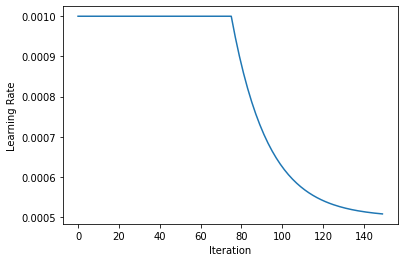

In [ ]:
lrs=[computeLR(i, epochs, 0.5*lrG,lrG) for i in range(epochs)]
plt.plot(lrs)
plt.xlabel('Iteration')
plt.ylabel('Learning Rate')

Let's initialize the net.

In [ ]:
from tensorflow.keras.optimizers import RMSprop, Adam

model=Bayes_DfpNet(expo=3,flipout=True,kl_scaling=kl_pref*len(X_train)/batch_size)
optimizer = Adam(learning_rate=lrG, beta_1=0.5,beta_2=0.9999)

num_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_variables])
print('Our Bayesian U-Net has {} parameters.'.format(num_params))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Our Bayesian U-Net has 133475 parameters.


Due to some differences in the implementation, the number of parameters is slightly lower than in the conventional neural network (147555), even though we use the same `expo` parameter. In general, flipout layers however come with twice as many parameters compared to their conventional counterparts, since instead of a single point estimate one has to learn both mean and variance parameters (for a Gaussian posterior).

Now we are ready to train!

## Training

In [ ]:
from tensorflow.keras.losses import mae
import math

kl_losses=[]
mae_losses=[]
total_losses=[]
val_maes=[]

for epoch in range(epochs):
    # compute learning rate - decay is implemented
    currLr = computeLR(epoch,epochs,0.5*lrG,lrG)
    if currLr < lrG:
            tf.keras.backend.set_value(optimizer.lr, currLr)

    # iterate through training data 
    kl_sum = 0
    mae_sum = 0
    total_sum=0
    for i, traindata in enumerate(dataset, 0):
      # forward pass and loss computation
        with tf.GradientTape() as tape:
            inputs, targets = traindata
            prediction = model(inputs)
            loss_mae = tf.reduce_mean(mae(prediction, targets))
            kl=sum(model.losses)
            loss_value=kl+tf.cast(loss_mae, dtype='float32')
        # backpropagate gradients and update parameters 
        gradients = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
   
        # store losses per batch
        kl_sum += kl
        mae_sum += tf.reduce_mean(loss_mae)
        total_sum+=tf.reduce_mean(loss_value)

    # store losses per epoch
    kl_losses+=[kl_sum/len(dataset)]
    mae_losses+=[mae_sum/len(dataset)]
    total_losses+=[total_sum/len(dataset)]

    # validation
    outputs = model.predict(X_val)
    val_maes += [tf.reduce_mean(mae(y_val, outputs))]

    if epoch<3 or epoch%20==0:
        print('Finnished epoch {}...'.format(epoch))
        print('total loss: {}'.format(total_losses[-1]))
        print('KL loss: {}'.format(kl_losses[-1]))
        print('MAE loss: {}'.format(mae_losses[-1]))
        print('Validation MAE loss: {}'.format(val_maes[-1]))
        print('----------------------------')

    

Finnished epoch 0...
total loss: 0.6994723081588745
KL loss: 0.5650137066841125
MAE loss: 0.13445863978867173
Validation MAE loss: 0.08071838319301605
----------------------------
Finnished epoch 1...
total loss: 0.629783034324646
KL loss: 0.5600312352180481
MAE loss: 0.06975189820671622
Validation MAE loss: 0.05924928933382034
----------------------------
Finnished epoch 2...
total loss: 0.6130387187004089
KL loss: 0.5546823143959045
MAE loss: 0.05835640023620712
Validation MAE loss: 0.053308360278606415
----------------------------
Finnished epoch 20...
total loss: 0.48715242743492126
KL loss: 0.45129039883613586
MAE loss: 0.035862083967624137
Validation MAE loss: 0.03532093018293381
----------------------------
Finnished epoch 40...
total loss: 0.3690536916255951
KL loss: 0.33777734637260437
MAE loss: 0.03127635233989842
Validation MAE loss: 0.02977834641933441
----------------------------
Finnished epoch 60...
total loss: 0.26104623079299927
KL loss: 0.23509857058525085
MAE loss: 0

The model is trained! Let's look at the loss. Since the loss consists of two separate parts, it is helpful to monitor both parts (MAE and KL).

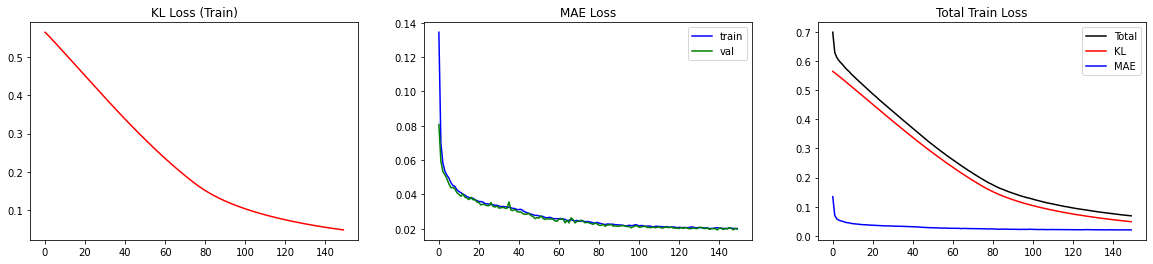

In [ ]:
fig,axs=plt.subplots(ncols=3,nrows=1,figsize=(20,4))
axs[0].plot(kl_losses,color='red')
axs[0].set_title('KL Loss (Train)')
axs[1].plot(mae_losses,color='blue',label='train')
axs[1].plot(val_maes,color='green',label='val')
axs[1].legend()
axs[1].set_title('MAE Loss')
axs[2].plot(total_losses,label='Total',color='black')
axs[2].plot(kl_losses,label='KL',color='red')
axs[2].plot(mae_losses,label='MAE',color='blue')
axs[2].set_title('Total Train Loss')
axs[2].legend()

This way, we can double-check if minimizing one part of the loss comes at the cost of increasing the other. For our case, we observe that both parts decrease smoothly. In particular the MAE loss is not increasing for the validation set, indicating that we are not overfitting. 

It is good practice to double-check how many layers added KL-losses. We can inspect _model.losses_ for that. Since the decoder consists of 6 sequential blocks with flipout layers, we expect 6 entries in _model.losses_.

In [ ]:
# there should be 6 entries in model.losses since we have 6 blocks with flipout layers in our model
print('There are {} entries in model.losses'.format(len(model.losses)))
print(model.losses)

There are 6 entries in model.losses
[<tf.Tensor: shape=(), dtype=float32, numpy=0.0023392083>, <tf.Tensor: shape=(), dtype=float32, numpy=0.00630205>, <tf.Tensor: shape=(), dtype=float32, numpy=0.01660155>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0093718935>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0072054924>, <tf.Tensor: shape=(), dtype=float32, numpy=0.006180173>]


Now let's visualize how the BNN performs for unseen data from the validation set. Since a forward pass is stochastic for BNNs, we will perform several forward passes for each input. This allows us to compute an average prediction (which is equivalent to marginalizing out the posterior distribution) and a standard deviation for each pixel.

In [ ]:
reps=20
preds=np.zeros(shape=(reps,)+X_val.shape)
for rep in range(reps):
    preds[rep,:,:,:,:]=model.predict(X_val)
preds_mean=np.mean(preds,axis=0)
preds_std=np.std(preds,axis=0)

In the first plot, the input is shown in the first row. The second row illustrates the result of a single forward pass. 

In the second plot, the average prediction is shown in the first row, and the corresponding uncertainty in the second row. 

First Row: Inputs, Second row: Single forward Pass


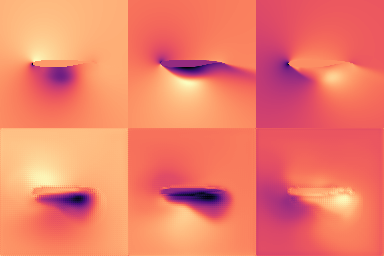

First Row: Average Prediction, Second row: Std. Deviation


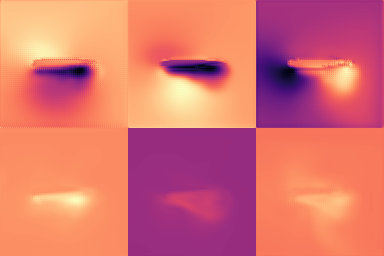

In [ ]:
num=16
# show some single prediction
print('First Row: Inputs, Second row: Single forward Pass')
showSbs(y_val[num],preds[0][num])

#show avg. pred in first row, std.deviation over prediction in second row
print('First Row: Average Prediction, Second row: Std. Deviation')
showSbs(preds_mean[num],preds_std[num])

We can visualize the uncertainty over predictions more clearly by inspecting several samples from the posterior distribution for a given input. Below is code for a function that visualizes precisely that.

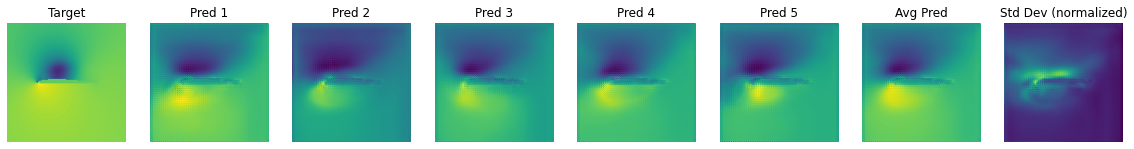

In [ ]:
# plot repeated samples from posterior for some observations
def plot_BNN_predictions(target, preds, pred_mean, pred_std, num_preds=5,channel=0):
  if num_preds>len(preds):
    print('num_preds was set to {}, but has to be smaller than the length of preds. Setting it to {}'.format(num_preds,len(preds)))
    num_preds = len(preds)

  # transpose and concatenate the frames that are to plot
  to_plot=np.concatenate((target[:,:,channel].transpose().reshape(128,128,1),preds[0:num_preds,:,:,channel].transpose(), 
                          pred_mean[:,:,channel].transpose().reshape(128,128,1),pred_std[:,:,channel].transpose().reshape(128,128,1)),axis=-1)
  fig, axs = plt.subplots(nrows=1,ncols=to_plot.shape[-1],figsize=(20,4))
  for i in range(to_plot.shape[-1]):
    label='Target' if i==0 else ('Avg Pred' if i == (num_preds+1) else ('Std Dev (normalized)' if i == (num_preds+2) else 'Pred {}'.format(i)))
    frame = np.flipud(to_plot[:,:,i])
    min=np.min(frame); max = np.max(frame)
    frame -= min; frame /=(max-min)
    axs[i].imshow(frame)
    axs[i].axis('off')
    axs[i].set_title(label)

obs_idx=5
plot_BNN_predictions(y_val[obs_idx,...],preds[:,obs_idx,:,:,:],preds_mean[obs_idx,...],preds_std[obs_idx,...])

We are looking at channel 0, i.e. the pressure here. One can observe that the blue and yellow regions vary quite a bit across predictions. It is reassuring to note that - at least from visual inspection - the average (i.e. marginal) prediction is closer to the target than most of the single forward passes. 

It should also be noted that each frame was normalized for the visualization. Therefore, when looking at the uncertainty frame, we can inferr where the network is uncertain, but now how uncertain it is in absolute values. 

In order to assess a global measure of uncertainty we can however compute an average standard deviation over all samples in the validation set.

In [ ]:
# Let's look at how uncertain the network is, i.e. average uncertainty over average prediction
uncertainty = np.round(np.mean(np.abs(preds_std),axis=(0,1,2))/np.mean(np.abs(preds_mean),axis=(0,1,2)),2)
print("\nAverage relative uncertainty on validation set: \n pressure: {}, \n ux: {},\n uy: {}".format(uncertainty[0],uncertainty[1],uncertainty[2]))


Average uncertainty on validation set: 
 pressure: 0.26, 
 ux: 0.03,
 uy: 0.16


In [ ]:
# average pixel-wise uncertainty over average pixel-wise prediction
uncertainty = np.round(np.mean(preds_std/np.abs(preds_mean),axis=(0,1,2)),2)
print("\nAverage relative pixe-wise uncertainty on validation set: \n pressure: {}, \n ux: {},\n uy: {}".format(uncertainty[0],uncertainty[1],uncertainty[2]))


Average relative pixe-wise uncertainty on validation set: 
 pressure: 1.7, 
 ux: 0.27,
 uy: 1.28


## Test evaluation

Like in the case for a conventional neural network, let's now look at **proper** test samples, i.e. OOD samples, for which in this case we'll use new airfoil shapes. These are shapes that the network never saw in any training samples, and hence it tells us a bit about how well the model generalizes to new shapes.

As these samples are at least slightly OOD, we can draw conclusions about how well the model generalizes, which the validation data would not really tell us. In particular, we would like to investigate if the model is more uncertain when handling OOD data.

In [ ]:
if not os.path.isfile('data-airfoils-test.npz'):
  import urllib.request
  url="https://ge.in.tum.de/download/2019-deepFlowPred/data_test.npz"
  print("Downloading test data, this should be fast...")
  urllib.request.urlretrieve(url, 'data-airfoils-test.npz')

nptfile=np.load('data-airfoils-test.npz')
print("Loaded {}/{} test samples".format(len(nptfile["test_inputs"]),len(nptfile["test_targets"])))

Loaded 10/10 test samples


In [ ]:
X_test = np.moveaxis(nptfile["test_inputs"],1,-1)
y_test = np.moveaxis(nptfile["test_targets"],1,-1)

reps=10
preds_test=np.zeros(shape=(reps,)+X_test.shape)
for rep in range(reps):
    preds_test[rep,:,:,:,:]=model.predict(X_test)
preds_test_mean=np.mean(preds_test,axis=0)
preds_test_std=np.std(preds_test,axis=0)
test_loss = tf.reduce_mean(mae(preds_test_mean, y_test))

print("\nAverage test error: {}".format(test_loss))


# Let's look at how uncertain the network is
uncertainty_std = np.round(np.mean(np.abs(preds_test_std),axis=(0,1,2))/np.mean(np.abs(preds_test_mean),axis=(0,1,2)),2)
print("\nAverage relative uncertainty on test set: \n pressure: {}, \n ux: {},\n uy: {}".format(uncertainty_std[0],uncertainty_std[1],uncertainty_std[2]))


Average test error: 0.025036948244479572

Average relative uncertainty on test set: 
 pressure: 0.27, 
 ux: 0.04,
 uy: 0.18


In [ ]:
# average pixel-wise uncertainty over average pixel-wise prediction
uncertainty = np.round(np.mean(preds_test_std/np.abs(preds_test_mean),axis=(0,1,2)),2)
print("\nAverage relative pixe-wise uncertainty on test set: \n pressure: {}, \n ux: {},\n uy: {}".format(uncertainty[0],uncertainty[1],uncertainty[2]))


Average relative pixe-wise uncertainty on test set: 
 pressure: 3.24, 
 ux: 0.18,
 uy: 1.58


## Check this, might not be true any more
This is reassuring: The error on the OOD test set with new shapes is higher than on the validation set. However, also the uncertainty is larger.
In general it is hard to obtain a calibrated uncertainty estimate, but since we are dealing with a fairly simple problem here, it seems that the BNN could estimate it reasonably well.

Text(0, 0.5, 'Relative Uncertainty')

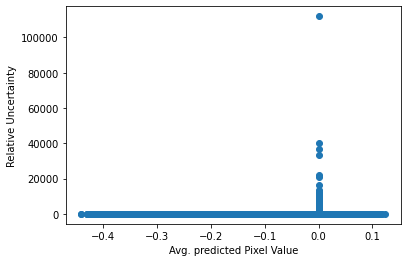

In [ ]:
# Why not to use pixel-wise uncertainty: Estimate is dominated by few pixels with low average prediction
# since we divide by pred_mean, a value of pred_mean close to 0 can lead to exploding relative uncertainties
plt.scatter(preds_mean[:,:,:,0],(preds_std[:,:,:,0]/np.abs(preds_mean[:,:,:,0])).flatten())
plt.xlabel('Avg. predicted Pixel Value')
plt.ylabel('Relative Uncertainty')

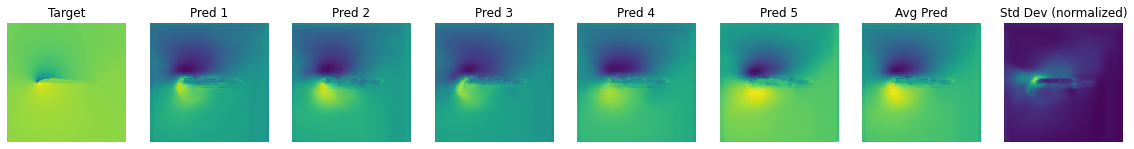

In [ ]:
obs_idx=5
plot_BNN_predictions(y_test[obs_idx,...],preds_test[:,obs_idx,:,:,:],preds_test_mean[obs_idx,...],preds_test_std[obs_idx,...])

Despite these promising results, there are still many issues with Bayesian Neural Nets, limiting their use in most practical applications. One serious drawback is the need for additional scaling of the KL-loss and the fact that there is no convincing argument on why it is necessary yet (read e.g. [here](http://proceedings.mlr.press/v119/wenzel20a/wenzel20a.pdf) or [here](https://arxiv.org/abs/2008.05912)).
Furthermore, some people think that assuming independent normal distributions as variational approximations to the posterior is an oversimplification since in practice the weights are actually highly correlated ([paper](https://arxiv.org/abs/1909.00719)). Other people instead argue that this might not be an issue, as long as the networks in use are deep enough ([paper](https://arxiv.org/abs/2002.03704)). On top of that, there is research on different (e.g. heavy-tailed) priors other than normals and many other aspects of BNNs.